# Part 1: Project

## Phase 1: Dataset Selection and Preprocessing

### 1. Databse Selection

In [8]:
# Importing Libraries & Set Seed
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


In [9]:
# Loading CIFAR-10 Dataset & Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


### 2. Data Preprocessing

In [10]:
# Train/Validation Split & DataLoader Setup 
from torch.utils.data import random_split, DataLoader

train_len = int(0.7 * len(full_trainset))
val_len = len(full_trainset) - train_len
trainset, valset = random_split(full_trainset, [train_len, val_len])

batch_size = 64
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


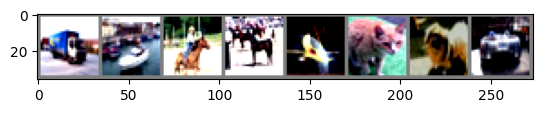

In [11]:
# Visualizing some sample images
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))


## Phase 2: Building a Machine Learning Model

### 3. Model Architecture

In [13]:
# Defining the CNN Model
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [14]:
# Initializing Model, Loss Function, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### 4. Training model

In [16]:
# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=3):
    best_loss = float('inf')
    patience_counter = 0
    history = {"train_loss": [], "val_loss": []}
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        history["train_loss"].append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
    return model, history


In [17]:
# Training Model on Clean Data
model, history = train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1, Train Loss: 1.3965, Val Loss: 1.1282
Epoch 2, Train Loss: 1.0117, Val Loss: 1.0079
Epoch 3, Train Loss: 0.8584, Val Loss: 0.8870
Epoch 4, Train Loss: 0.7452, Val Loss: 0.9100
Epoch 5, Train Loss: 0.6454, Val Loss: 0.8689
Epoch 6, Train Loss: 0.5448, Val Loss: 0.9019
Epoch 7, Train Loss: 0.4644, Val Loss: 0.9280
Epoch 8, Train Loss: 0.3740, Val Loss: 1.0015
Early stopping triggered.


### 5. baseline Performance Metrices

Clean Test Accuracy:70.11%


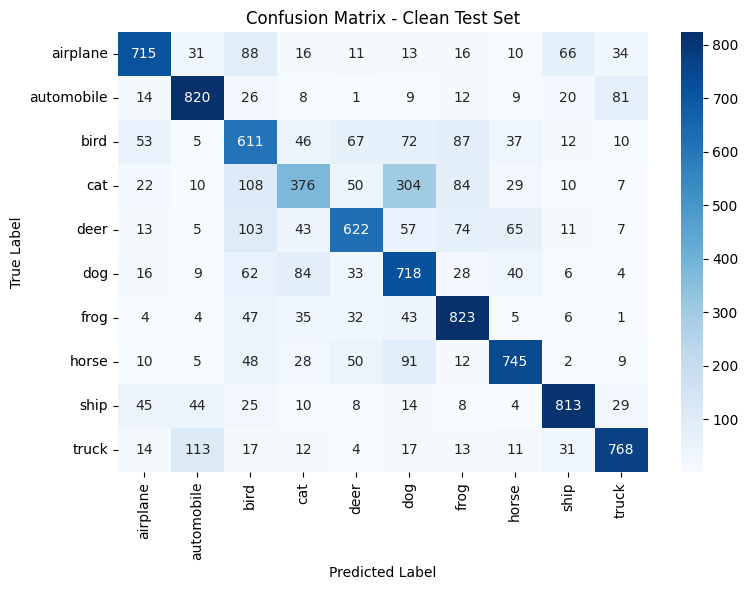



Validation Accuracy:70.26%


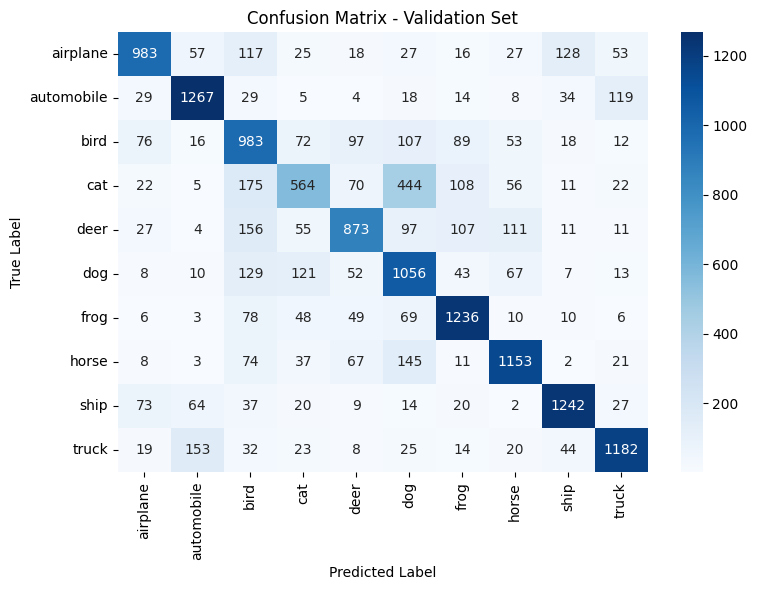

In [18]:
# Baseline Performance Metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Test set
test_preds, test_labels = get_predictions(model, test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"Clean Test Accuracy:{test_accuracy * 100:.2f}%")
plot_confusion_matrix(test_labels, test_preds, classes, "Confusion Matrix - Clean Test Set")

# Validation set
val_preds, val_labels = get_predictions(model, val_loader)
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"\n\nValidation Accuracy:{val_accuracy * 100:.2f}%")
plot_confusion_matrix(val_labels, val_preds, classes, "Confusion Matrix - Validation Set")

# Phase 3: Training-Time Attacks (Data Poisoning) 

### 6. Poisoning Attack Implementation

In [19]:
# Label Flipping Attack 

def poison_labels(dataset, num_classes=10, poison_fraction=0.15):
    indices = list(dataset.indices) if hasattr(dataset, 'indices') else list(range(len(dataset)))
    targets = np.array([dataset.dataset.targets[i] for i in indices])
    num_poison = int(poison_fraction * len(targets))
    poison_idx = random.sample(range(len(targets)), num_poison)
    poisoned_targets = targets.copy()
    for idx in poison_idx:
        old_label = poisoned_targets[idx]
        new_label = random.choice([i for i in range(num_classes) if i != old_label])
        poisoned_targets[idx] = new_label
    poisoned_subset = []
    for i, idx in enumerate(indices):
        img, _ = dataset.dataset[idx]
        poisoned_subset.append((img, torch.tensor(poisoned_targets[i], dtype=torch.long)))

    return poisoned_subset

# Poison 15% of training data
poisoned_trainset = poison_labels(trainset, num_classes=10, poison_fraction=0.15)
poisoned_train_loader = DataLoader(poisoned_trainset, batch_size=batch_size, shuffle=True)


### 7. Poisoned Model Evaluation

In [20]:
# Retraining Model on Poisoned Data

poisoned_model = SimpleCNN().to(device)
optimizer = optim.Adam(poisoned_model.parameters(), lr=0.001)
poisoned_model, _ = train_model(poisoned_model, poisoned_train_loader, val_loader, criterion, optimizer)


Epoch 1, Train Loss: 1.7630, Val Loss: 1.2522
Epoch 2, Train Loss: 1.5072, Val Loss: 1.1242
Epoch 3, Train Loss: 1.3840, Val Loss: 1.0646
Epoch 4, Train Loss: 1.2873, Val Loss: 1.0269
Epoch 5, Train Loss: 1.1855, Val Loss: 1.0265
Epoch 6, Train Loss: 1.0778, Val Loss: 1.0694
Epoch 7, Train Loss: 0.9664, Val Loss: 1.1322
Epoch 8, Train Loss: 0.8462, Val Loss: 1.1537
Early stopping triggered.


In [21]:
# Create a POISONED validation set

poisoned_valset = poison_labels(valset, num_classes = 10, poison_fraction = 1.0)
poisoned_val_loader = DataLoader(poisoned_valset, batch_size = batch_size, shuffle = False)


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_conf_matrix(conf_matrix, labels, title, accuracy):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=labels, yticklabels=labels, linewidths=0.5)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{title}\nAccuracy: {accuracy:.4f}')
    plt.show()

def print_colored_accuracy(label, acc):
    from IPython.display import display, Markdown
    color = "green" if acc > 0.5 else "orange" if acc > 0.2 else "red"
    display(Markdown(f"**<span style='color:{color}'>{label} Accuracy: {acc:.4f}</span>**"))

# Example class names for CIFAR-10
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


**<span style='color:green'>Model - Clean Test Accuracy: 0.6275</span>**

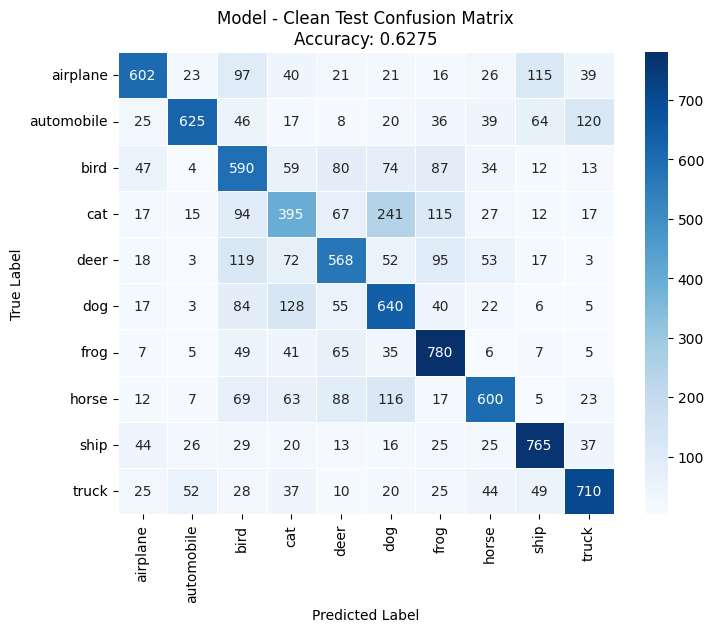

**<span style='color:red'>Model - Poisoned Validation Accuracy: 0.0419</span>**

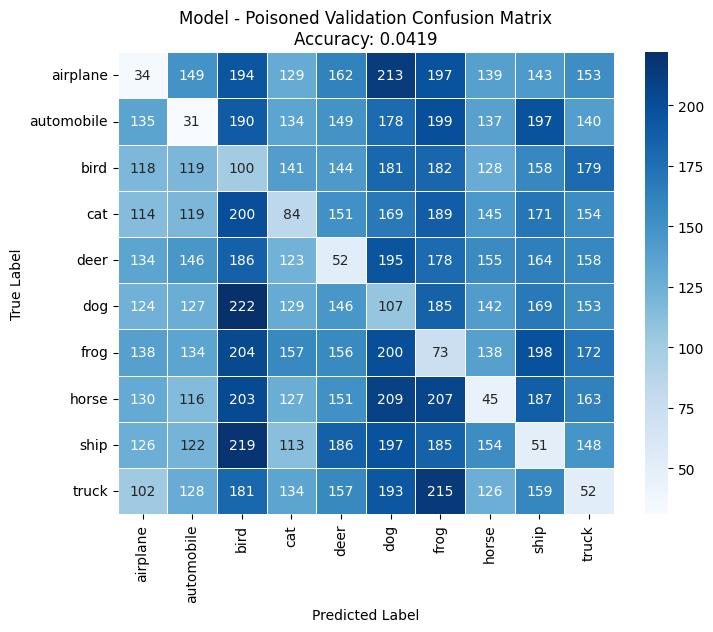

**<span style='color:green'>Model - Original Validation Accuracy: 0.6285</span>**

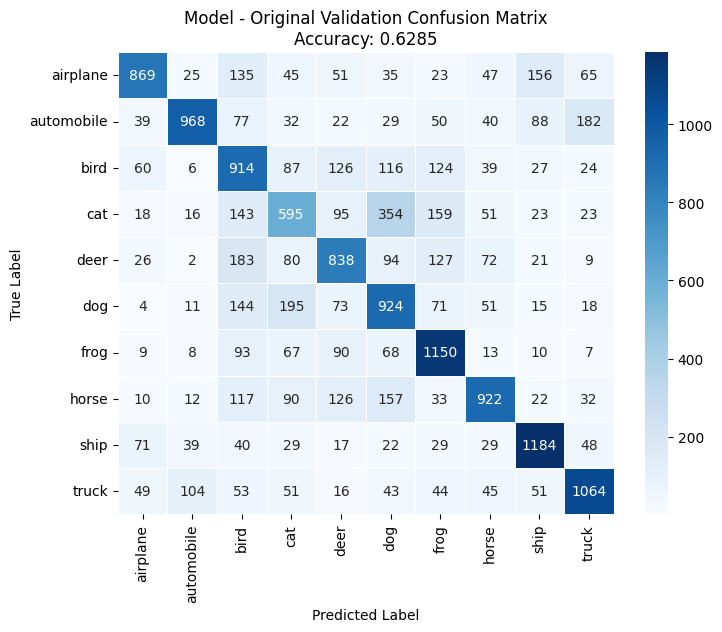

In [23]:
#Compare performance degradation using POISONED label-flip-trained model 

poisoned_test_preds, poisoned_test_labels = get_predictions(poisoned_model, test_loader)
poisoned_val_preds, poisoned_val_labels = get_predictions(poisoned_model, poisoned_val_loader)
orig_val_preds, orig_val_labels = get_predictions(poisoned_model, val_loader)

# Clean Test Set
print_colored_accuracy('Model - Clean Test', accuracy_score(poisoned_test_labels, poisoned_test_preds))
plot_conf_matrix(confusion_matrix(poisoned_test_labels, poisoned_test_preds), class_names,
                 'Model - Clean Test Confusion Matrix', accuracy_score(poisoned_test_labels, poisoned_test_preds))

# Poisoned Validation Set
print_colored_accuracy('Model - Poisoned Validation', accuracy_score(poisoned_val_labels, poisoned_val_preds))
plot_conf_matrix(confusion_matrix(poisoned_val_labels, poisoned_val_preds), class_names,
                 'Model - Poisoned Validation Confusion Matrix', accuracy_score(poisoned_val_labels, poisoned_val_preds))

# Original Clean Validation Set
print_colored_accuracy('Model - Original Validation', accuracy_score(orig_val_labels, orig_val_preds))
plot_conf_matrix(confusion_matrix(orig_val_labels, orig_val_preds), class_names,
                 'Model - Original Validation Confusion Matrix', accuracy_score(orig_val_labels, orig_val_preds))


# Phase 4: Inference-Time Attacks (Adversarial Examples)

### 8. Adversarial Attack Generation

### White-Box Attack: PGD Implementation

In [24]:
# SecMl Classifier Wrapper for PyTorch Model

from secml.ml.classifiers import CClassifierPyTorch
poisoned_model.eval()
cmodel = CClassifierPyTorch(poisoned_model, input_shape=(3, 32, 32), softmax_outputs=False)


In [25]:
# Preparing CIFAR-10 test set for SECML
from secml.data import CDataset
X_test = []
y_test = []
for imgs, labels in test_loader:
    X_test.append(imgs.numpy())
    y_test.append(labels.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

X_test_flat = X_test.reshape((X_test.shape[0], -1))
ds_test = CDataset(X_test_flat, y_test)


In [53]:
# SECML White-box attack

from secml.adv.attacks import CAttackEvasionPGD
import numpy as np

# PGD attack parameters 
noise_type = 'l2'
dmax = 0.1              
y_target = None

solver_params = {
    'eta': 0.025,       
    'max_iter': 50,     
    'eps': 1e-4
}

cmodel.__dict__['_classes'] = np.unique(y_test)
cmodel.__dict__['_n_features'] = ds_test.X.shape[1]
cmodel.__dict__['_is_fitted'] = True
N = 10
attack_ds = ds_test[[i for i in range(N)], :]  # SECML tuple-style subsetting

attack = CAttackEvasionPGD(
    cmodel,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=-2.0, ub=2.2,   
    y_target=None,
    attack_classes='all',
    solver_params=solver_params
)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = attack.run(attack_ds.X, attack_ds.Y)

# Convert SECML adversarial samples to PyTorch tensors for randomized smoothing
adv_images = torch.tensor(eva_adv_ds.X.tondarray()).float().to(device)
adv_labels = torch.tensor(eva_adv_ds.Y.tondarray()).long().to(device)
adv_images = adv_images.view(-1, 3, 32, 32)

print("Attack complete!\n")


Attack started...
Attack complete!



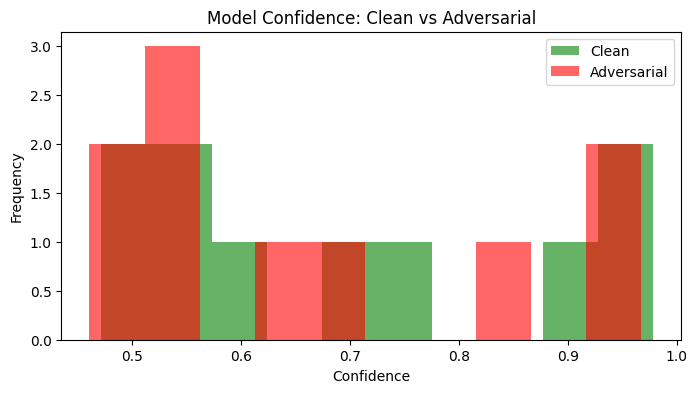

In [54]:
# Confidence Score Visualization
import matplotlib.pyplot as plt
import numpy as np

# Get softmax scores for clean and adversarial
softmax = lambda x: np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)
clean_logits = cmodel.decision_function(attack_ds.X).tondarray()
adv_logits = cmodel.decision_function(eva_adv_ds.X).tondarray()

clean_conf = softmax(clean_logits).max(axis=1)
adv_conf = softmax(adv_logits).max(axis=1)

plt.figure(figsize=(8,4))
plt.hist(clean_conf, bins=10, alpha=0.6, label='Clean', color='g')
plt.hist(adv_conf, bins=10, alpha=0.6, label='Adversarial', color='r')
plt.title("Model Confidence: Clean vs Adversarial")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.legend()
plt.show()


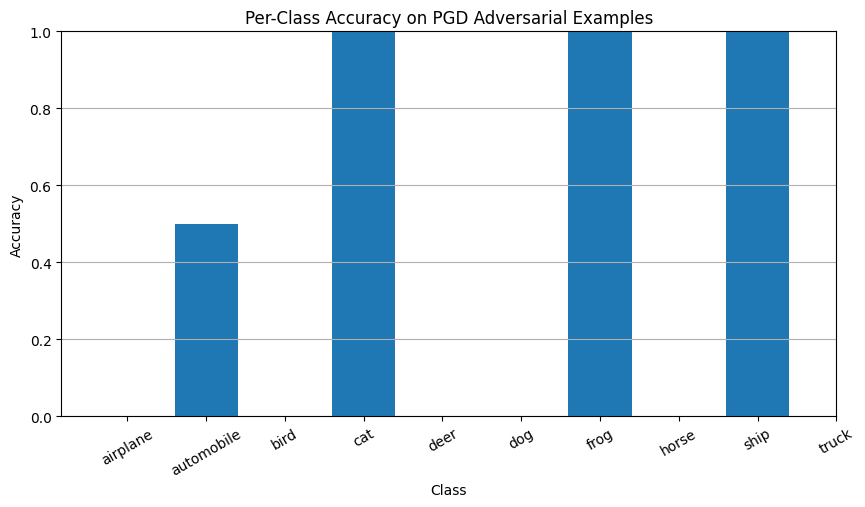

In [55]:
# Per-Class Vulnerability Barplot

# Make sure you have class names defined:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Compute per-class accuracy on adversarial (PGD) examples
y_true = eva_adv_ds.Y.tondarray()
y_pred = eva_y_pred.tondarray() if hasattr(eva_y_pred, 'tondarray') else np.array(eva_y_pred)
num_classes = len(class_names)

class_acc = []
for c in range(num_classes):
    idx = np.where(y_true == c)[0]
    # If a class does not appear in y_true, set accuracy as np.nan (to avoid division by zero)
    if len(idx) > 0:
        class_acc.append((y_pred[idx] == y_true[idx]).mean())
    else:
        class_acc.append(np.nan)

plt.figure(figsize=(10,5))
plt.bar(range(num_classes), class_acc)
plt.xticks(range(num_classes), class_names, rotation=30)
plt.title("Per-Class Accuracy on PGD Adversarial Examples")
plt.ylabel("Accuracy")
plt.xlabel("Class")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [56]:
from secml.array import CArray

# Compare predictions
y_clean_pred = cmodel.predict(attack_ds.X)
y_adv_pred = cmodel.predict(eva_adv_ds.X)
true_labels = attack_ds.Y
correct_before = y_clean_pred == true_labels
changed_prediction = y_clean_pred != y_adv_pred
success = correct_before.logical_and(changed_prediction)
success_rate = success.sum() / success.size

print(f"Attack Success Rate: {success_rate * 100:.2f}%")


Attack Success Rate: 0.00%


In [57]:
import matplotlib.pyplot as plt
import numpy as np

def unflatten_img(flat_img):
    return flat_img.tondarray().reshape(3, 32, 32)

mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.247, 0.243, 0.261])

def denormalize(img):
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return np.clip(img, 0, 1)

def show_multiple_clean_vs_adv(indices):
    num = len(indices)
    fig, axes = plt.subplots(num, 3, figsize=(10, 2.5 * num))

    if num == 1:
        axes = [axes]  # ensure axes is iterable for single case

    for i, idx in enumerate(indices):
        clean = attack_ds.X[idx, :]
        adv = eva_adv_ds.X[idx, :]
        true_label = int(attack_ds.Y[idx].item())
        pred_clean = int(cmodel.predict(clean).item())
        pred_adv = int(cmodel.predict(adv).item())

        clean_img = denormalize(unflatten_img(clean))
        adv_img = denormalize(unflatten_img(adv))
        diff_img = np.abs(adv_img - clean_img)

        images = [clean_img, adv_img, diff_img]
        titles = [f"Clean (Pred: {pred_clean})", 
                  f"Adv (Pred: {pred_adv})", 
                  "Perturbation"]

        for j in range(3):
            ax = axes[i][j] if num > 1 else axes[j]
            ax.imshow(np.transpose(images[j], (1, 2, 0)))
            ax.axis('off')
            ax.set_title(titles[j])

    plt.suptitle("Clean vs Adversarial Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()


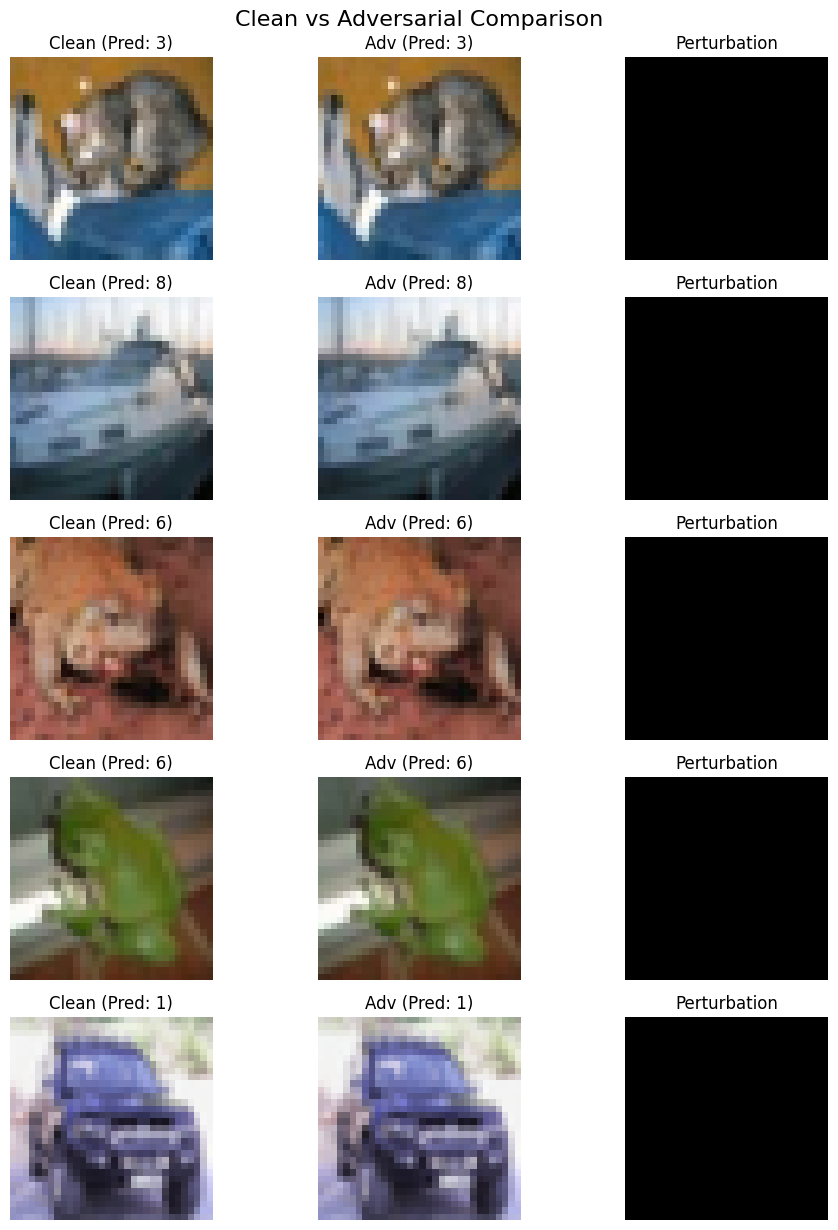

In [58]:
print("\n\n")
show_multiple_clean_vs_adv([0,2,5,7,9])


### Black-box Attack (Transfer from Surrogate)

In [30]:
# Creating Surrogate Dataset from CIFAR-10

from secml.data import CDataset
from secml.ml.features import CNormalizerMinMax

N_SURR = 1000 
X_surr = []
y_surr = []

for images, labels in test_loader:
    for i in range(images.size(0)):
        if len(X_surr) < N_SURR:
            X_surr.append(images[i].numpy())
            y_surr.append(labels[i].item())
        else:
            break
    if len(X_surr) >= N_SURR:
        break

X_surr = np.stack(X_surr)  # shape (N, 3, 32, 32)
X_surr_flat = X_surr.reshape((N_SURR, -1))  # shape (N, 3072)
y_surr = np.array(y_surr)

normalizer = CNormalizerMinMax()
X_surr_flat = normalizer.fit_transform(X_surr_flat)

ds_surr = CDataset(X_surr_flat, y_surr)

print(f"Surrogate dataset created: {ds_surr.num_samples} samples, {ds_surr.num_features} features")


Surrogate dataset created: 1000 samples, 3072 features


In [31]:
# Training Surrogate Classifier (Linear SVM)

from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.classifiers import CClassifierSVM
from secml.data.splitter import CDataSplitterKFold
from secml.ml.peval.metrics import CMetricAccuracy

surr_clf = CClassifierMulticlassOVA(CClassifierSVM, kernel='linear')

xval_params = {'C': [1e-2, 0.1, 1]}
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=42)
metric = CMetricAccuracy()

print("Estimating the best training parameters for surrogate SVM...")
best_params = surr_clf.estimate_parameters(
    dataset=ds_surr,
    parameters=xval_params,
    splitter=xval_splitter,
    metric=metric,
    perf_evaluator='xval'
)
print("Best parameters:", best_params)

surr_clf.fit(ds_surr.X, ds_surr.Y)

# Evaluating performance
y_pred_surr = surr_clf.predict(ds_surr.X)
acc_surr = metric.performance_score(ds_surr.Y, y_pred_surr)

print(f"Accuracy of surrogate SVM on surrogate dataset: {acc_surr * 100:.2f}%")


Estimating the best training parameters for surrogate SVM...
Best parameters: {'C': 0.01}
Accuracy of surrogate SVM on surrogate dataset: 80.50%


In [23]:
# Generating Adversarial Examples from Surrogate (PGD-LS) 

from secml.adv.attacks.evasion import CAttackEvasionPGDLS

# Attack parameters
noise_type = 'l2'
dmax = 0.1        # ε ≤ 0.1 budget as required
lb, ub = 0.0, 1.0  # bounds after MinMax normalization
y_target = None   # error-generic attack

solver_params = {
    'eta': 0.1,
    'eta_min': 0.01,
    'eta_max': None,
    'max_iter': 50,
    'eps': 1e-4
}

attack = CAttackEvasionPGDLS(
    classifier=surr_clf,
    double_init_ds=ds_surr,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=lb, ub=ub,
    y_target=y_target,
    solver_params=solver_params
)

N_ATTACK = 100
attack_ds = ds_surr[:N_ATTACK, :]

print("Running surrogate-based PGD-LS attack...")
adv_labels, _, adv_ds, _ = attack.run(attack_ds.X, attack_ds.Y)
print("Attack complete!")


Running surrogate-based PGD-LS attack...
Attack complete!


In [24]:
# Evaluating Transferability of Surrogate Attack on CNN 
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.247, 0.243, 0.261])

def convert_to_tensor_img(flat_img):
    img = flat_img.tondarray().reshape((3, 32, 32))
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = np.clip(img, 0, 1)
    
    tensor_img = torch.tensor(img, dtype=torch.float)
    # Ensure shape is (3, 32, 32)
    tensor_img = tensor_img.view(3, 32, 32)
    return tensor_img

adv_tensors = []
adv_labels = []

for i in range(adv_ds.num_samples):
    flat_img = adv_ds.X[i, :].ravel() 
    adv_img = convert_to_tensor_img(flat_img)
    adv_tensors.append(adv_img)
    adv_labels.append(int(adv_ds.Y[i].item()))

adv_images = torch.stack(adv_tensors)  
print(f"adv_images shape before reshape: {adv_images.shape}")  

adv_images = adv_images.view(-1, 3, 32, 32)
print(f"adv_images shape after reshape: {adv_images.shape}")

adv_labels = torch.tensor(adv_labels)
adv_images = adv_images.to(device)
adv_labels = adv_labels.to('cpu')  # sklearn expects CPU tensor

print(f"adv_images final shape before model call: {adv_images.shape}")
print(f"adv_labels shape: {adv_labels.shape}")

model.eval()
with torch.no_grad():
    outputs = model(adv_images)
    _, preds = torch.max(outputs, 1)

from sklearn.metrics import accuracy_score
cnn_acc_on_adv = accuracy_score(adv_labels.cpu(), preds.cpu())
print(f"SimpleCNN Accuracy on Surrogate Adversarial Examples: {cnn_acc_on_adv * 100:.2f}%")

adv_images shape before reshape: torch.Size([100, 3, 32, 32])
adv_images shape after reshape: torch.Size([100, 3, 32, 32])
adv_images final shape before model call: torch.Size([100, 3, 32, 32])
adv_labels shape: torch.Size([100])
SimpleCNN Accuracy on Surrogate Adversarial Examples: 19.00%


### 9.	Attack Impact Analysis

Adversarial Success Rate: 26.00%


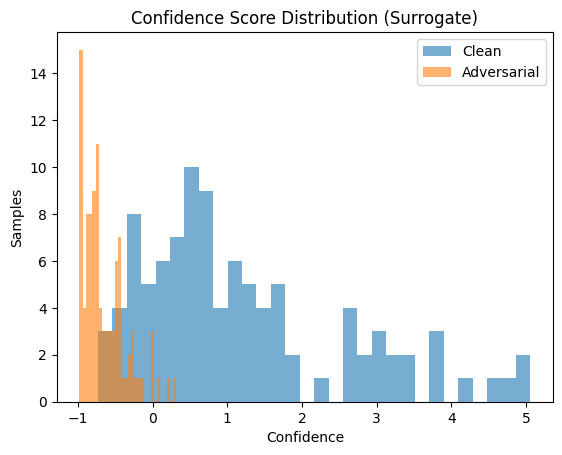

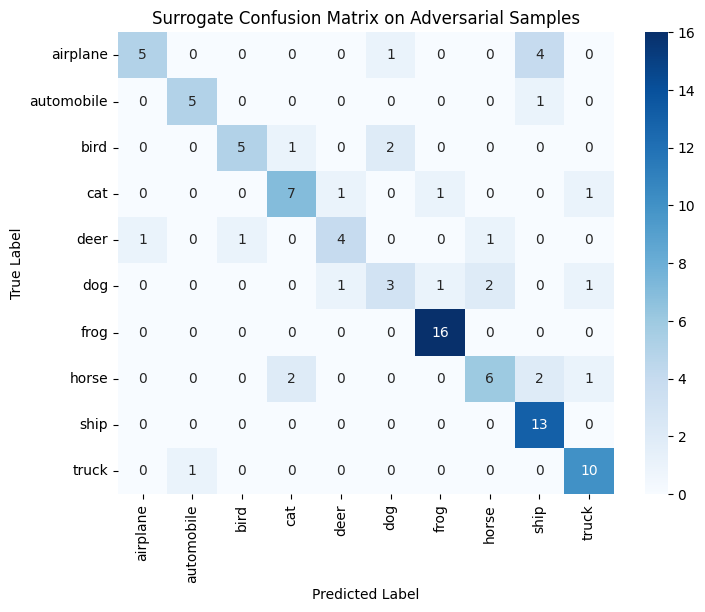

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from secml.ml.peval.metrics import CMetricAccuracy

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

metric = CMetricAccuracy()
n_adv = adv_ds.num_samples
clean_subset = ds_test[:n_adv, :]
adv_success_rate = 1 - metric.performance_score(y_true=clean_subset.Y, y_pred=surr_clf.predict(adv_ds.X))
print(f"Adversarial Success Rate: {adv_success_rate*100:.2f}%")

conf_clean = surr_clf.decision_function(clean_subset.X).max(axis=1).tondarray()
conf_adv = surr_clf.decision_function(adv_ds.X).max(axis=1).tondarray()

plt.hist(conf_clean, bins=30, alpha=0.6, label='Clean')
plt.hist(conf_adv, bins=30, alpha=0.6, label='Adversarial')
plt.legend()
plt.title("Confidence Score Distribution (Surrogate)")
plt.xlabel("Confidence")
plt.ylabel("Samples")
plt.show()

# 3. Confusion Matrix
y_true = adv_ds.Y.tondarray()
y_pred = surr_clf.predict(adv_ds.X).tondarray()
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Surrogate Confusion Matrix on Adversarial Samples")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Phase 5: Comprehensive Evaluation

### 10.	Cross-Attack Susceptibility

Running white-box PGD attack on poisoned CNN...
White-box PGD attack complete!
Poisoned Model on Clean Samples Accuracy: 20.00%
Poisoned Model on Surrogate Adversarial Samples Accuracy: 14.00%
Poisoned Model on White-box PGD Adversarial Samples Accuracy: 19.00%


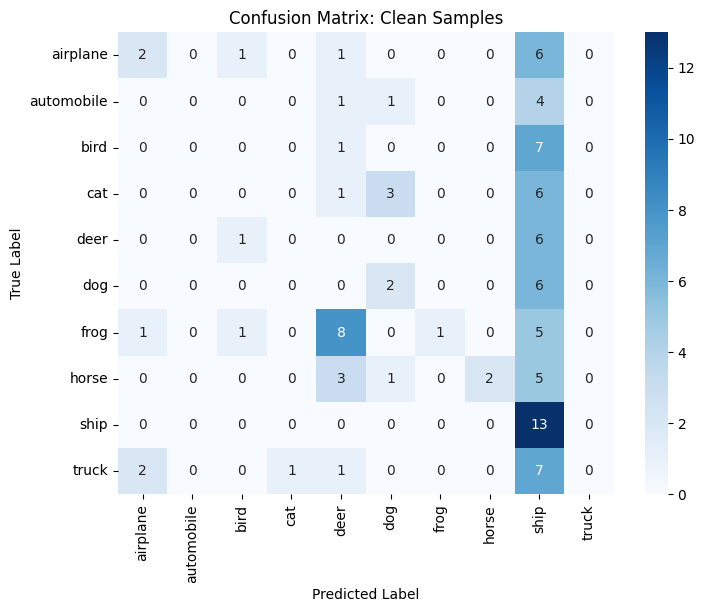

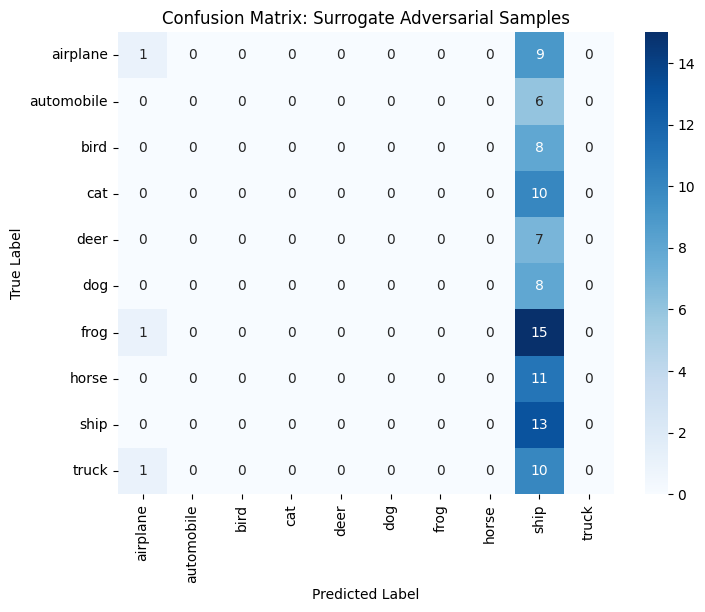

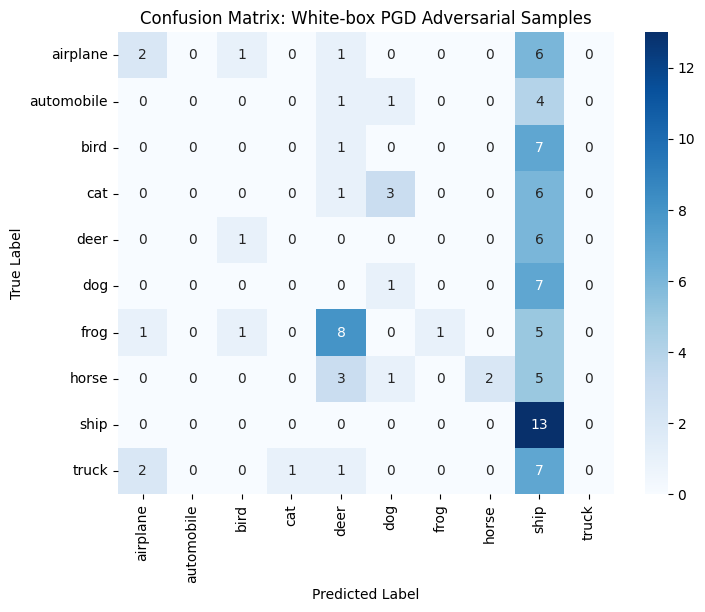

Surrogate Attack Success Rate: 6.00%
White-box PGD Attack Success Rate: 1.00%
Overlap Attack Success Rate (both attacks): 1.00%


In [26]:
from secml.adv.attacks import CAttackEvasionPGD
from secml.ml.peval.metrics import CMetricAccuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

N_eval = 100 
eval_ds = ds_test[:N_eval, :] 

pgd_attack = CAttackEvasionPGD(
    classifier=cmodel,
    double_init=False,
    distance='l2',
    dmax=0.1,
    lb=-2.0, ub=2.2,
    solver_params={'max_iter': 50, 'eta': 0.025, 'eps': 1e-4}
)

print("Running white-box PGD attack on poisoned CNN...")
_, _, adv_ds_pgd, _ = pgd_attack.run(eval_ds.X, eval_ds.Y)
print("White-box PGD attack complete!")

def secml_to_torch_tensor(carray_imgs):
    imgs = []
    for i in range(carray_imgs.shape[0]):
        flat_img = carray_imgs[i, :]
        img = flat_img.tondarray().reshape(3, 32, 32)
        # Denormalize (using CIFAR-10 mean/std)
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.247, 0.243, 0.261])
        for c in range(3):
            img[c] = img[c] * std[c] + mean[c]
        img = np.clip(img, 0, 1)
        imgs.append(torch.tensor(img, dtype=torch.float))
    return torch.stack(imgs).to(device)

clean_imgs = secml_to_torch_tensor(eval_ds.X)
clean_labels = torch.tensor(eval_ds.Y.tondarray(), dtype=torch.long).to(device)

adv_imgs_surr = secml_to_torch_tensor(adv_ds.X)
adv_labels_surr = torch.tensor(adv_ds.Y.tondarray(), dtype=torch.long).to(device)

adv_imgs_pgd = secml_to_torch_tensor(adv_ds_pgd.X)
adv_labels_pgd = torch.tensor(adv_ds_pgd.Y.tondarray(), dtype=torch.long).to(device)

def evaluate_model(model, inputs, labels, description):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    acc = (preds == labels).float().mean().item()
    print(f"{description} Accuracy: {acc*100:.2f}%")
    return preds.cpu().numpy(), labels.cpu().numpy()

pred_clean, true_clean = evaluate_model(poisoned_model, clean_imgs, clean_labels, "Poisoned Model on Clean Samples")

pred_adv_surr, true_adv_surr = evaluate_model(poisoned_model, adv_imgs_surr, adv_labels_surr, "Poisoned Model on Surrogate Adversarial Samples")

pred_adv_pgd, true_adv_pgd = evaluate_model(poisoned_model, adv_imgs_pgd, adv_labels_pgd, "Poisoned Model on White-box PGD Adversarial Samples")

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

plot_cm(true_clean, pred_clean, "Confusion Matrix: Clean Samples")
plot_cm(true_adv_surr, pred_adv_surr, "Confusion Matrix: Surrogate Adversarial Samples")
plot_cm(true_adv_pgd, pred_adv_pgd, "Confusion Matrix: White-box PGD Adversarial Samples")

def attack_success(y_true, y_pred_clean, y_pred_adv):
    success = (y_pred_clean == y_true) & (y_pred_adv != y_true)
    return success

success_surr = attack_success(true_clean, pred_clean, pred_adv_surr)
success_pgd = attack_success(true_clean, pred_clean, pred_adv_pgd)

print(f"Surrogate Attack Success Rate: {success_surr.mean()*100:.2f}%")
print(f"White-box PGD Attack Success Rate: {success_pgd.mean()*100:.2f}%")

# Overlap: samples misclassified by BOTH attacks
overlap = success_surr & success_pgd
print(f"Overlap Attack Success Rate (both attacks): {overlap.mean()*100:.2f}%")

In [27]:
from secml.adv.attacks import CAttackEvasionPGD
import torch
import numpy as np

N_eval = 100
eval_ds = ds_test[:N_eval, :]

# White-box PGD attack on poisoned model
pgd_attack = CAttackEvasionPGD(
    classifier=cmodel,
    double_init=False,
    distance='l2',
    dmax=0.1,
    lb=-2.0, ub=2.2,
    solver_params={'max_iter': 50, 'eta': 0.025, 'eps': 1e-4}
)
print("Running white-box PGD attack...")
_, _, adv_ds_pgd, _ = pgd_attack.run(eval_ds.X, eval_ds.Y)
print("PGD attack done.")

def secml_to_torch(carray_imgs):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.247, 0.243, 0.261])
    imgs = []
    for i in range(carray_imgs.shape[0]):
        img = carray_imgs[i, :].tondarray().reshape(3, 32, 32)
        for c in range(3):
            img[c] = img[c] * std[c] + mean[c]
        img = np.clip(img, 0, 1)
        imgs.append(torch.tensor(img, dtype=torch.float))
    return torch.stack(imgs).to(device)

# Convert datasets
clean_imgs = secml_to_torch(eval_ds.X)
clean_labels = torch.tensor(eval_ds.Y.tondarray(), dtype=torch.long).to(device)

adv_imgs_surr = secml_to_torch(adv_ds.X)
adv_labels_surr = torch.tensor(adv_ds.Y.tondarray(), dtype=torch.long).to(device)

adv_imgs_pgd = secml_to_torch(adv_ds_pgd.X)
adv_labels_pgd = torch.tensor(adv_ds_pgd.Y.tondarray(), dtype=torch.long).to(device)

# Evaluate model helper
def evaluate(model, inputs, labels):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    accuracy = (preds == labels).float().mean().item()
    return preds.cpu().numpy(), labels.cpu().numpy(), accuracy

# Evaluate poisoned model on datasets
pred_clean, true_clean, acc_clean = evaluate(poisoned_model, clean_imgs, clean_labels)
print(f"Accuracy on clean samples: {acc_clean*100:.2f}%")

pred_adv_surr, true_adv_surr, acc_adv_surr = evaluate(poisoned_model, adv_imgs_surr, adv_labels_surr)
print(f"Accuracy on surrogate adversarial samples: {acc_adv_surr*100:.2f}%")

pred_adv_pgd, true_adv_pgd, acc_adv_pgd = evaluate(poisoned_model, adv_imgs_pgd, adv_labels_pgd)
print(f"Accuracy on white-box PGD adversarial samples: {acc_adv_pgd*100:.2f}%")

# Attack success calculation
def attack_success(y_true, pred_clean, pred_adv):
    return (pred_clean == y_true) & (pred_adv != y_true)

success_surr = attack_success(true_clean, pred_clean, pred_adv_surr)
success_pgd = attack_success(true_clean, pred_clean, pred_adv_pgd)

print(f"Surrogate Attack Success Rate: {success_surr.mean()*100:.2f}%")
print(f"White-box PGD Attack Success Rate: {success_pgd.mean()*100:.2f}%")

overlap = success_surr & success_pgd
print(f"Overlap Attack Success Rate: {overlap.mean()*100:.2f}%")


Running white-box PGD attack...
PGD attack done.
Accuracy on clean samples: 20.00%
Accuracy on surrogate adversarial samples: 14.00%
Accuracy on white-box PGD adversarial samples: 19.00%
Surrogate Attack Success Rate: 6.00%
White-box PGD Attack Success Rate: 1.00%
Overlap Attack Success Rate: 1.00%


### 11.	Vulnerability Report
### (a) Create visualization

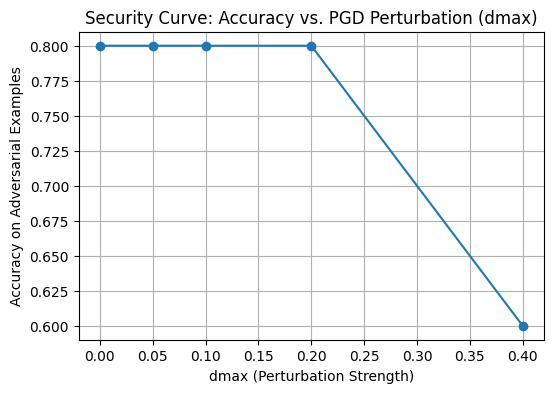

In [40]:
dmax_values = [0.0, 0.05, 0.1, 0.2, 0.4]
adv_accs = []

for d in dmax_values:
    attack = CAttackEvasionPGD(
        cmodel,
        double_init=False,
        distance='l2',
        dmax=d,
        lb=-2.0, ub=2.2,
        y_target=None,
        attack_classes='all',
        solver_params={'eta': 0.025, 'max_iter': 50, 'eps': 1e-4}
    )
    y_pred, _, adv_ds, _ = attack.run(attack_ds.X, attack_ds.Y)
    y_pred = y_pred.tondarray() if hasattr(y_pred, 'tondarray') else np.array(y_pred)
    y_true = adv_ds.Y.tondarray() if hasattr(adv_ds.Y, 'tondarray') else np.array(adv_ds.Y)
    acc = (y_pred == y_true).mean()
    adv_accs.append(acc)

plt.figure(figsize=(6,4))
plt.plot(dmax_values, adv_accs, marker='o')
plt.title("Security Curve: Accuracy vs. PGD Perturbation (dmax)")
plt.xlabel("dmax (Perturbation Strength)")
plt.ylabel("Accuracy on Adversarial Examples")
plt.grid(True)
plt.show()


### Security Curve for Accuracy vs. Poisoned Samples Fraction

Epoch 1, Train Loss: 1.3510, Val Loss: 1.0768
Epoch 2, Train Loss: 0.9703, Val Loss: 0.9599
Epoch 3, Train Loss: 0.8058, Val Loss: 0.8668
Epoch 4, Train Loss: 0.6748, Val Loss: 0.8761
Epoch 5, Train Loss: 0.5596, Val Loss: 0.9056
Epoch 6, Train Loss: 0.4496, Val Loss: 0.9119
Early stopping triggered.
Epoch 1, Train Loss: 1.5336, Val Loss: 1.1751
Epoch 2, Train Loss: 1.2115, Val Loss: 1.0483
Epoch 3, Train Loss: 1.0632, Val Loss: 0.9623
Epoch 4, Train Loss: 0.9375, Val Loss: 0.9221
Epoch 5, Train Loss: 0.8227, Val Loss: 0.9151
Epoch 6, Train Loss: 0.7021, Val Loss: 0.9189
Epoch 7, Train Loss: 0.5870, Val Loss: 0.9975
Epoch 8, Train Loss: 0.4706, Val Loss: 1.0873
Early stopping triggered.
Epoch 1, Train Loss: 1.6555, Val Loss: 1.2548
Epoch 2, Train Loss: 1.3641, Val Loss: 1.0938
Epoch 3, Train Loss: 1.2256, Val Loss: 1.0066
Epoch 4, Train Loss: 1.1169, Val Loss: 0.9939
Epoch 5, Train Loss: 1.0076, Val Loss: 0.9636
Epoch 6, Train Loss: 0.8958, Val Loss: 0.9873
Epoch 7, Train Loss: 0.7776,

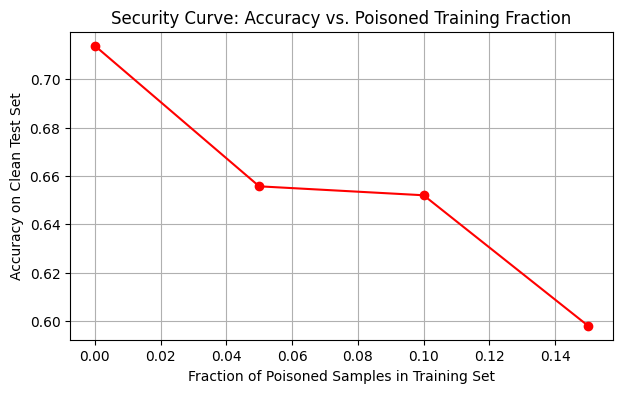

In [42]:
poison_fractions = [0.0, 0.05, 0.10, 0.15]
test_accs = []

for frac in poison_fractions:
    # Poison training set with fraction 'frac'
    poisoned_trainset = poison_labels(trainset, num_classes=10, poison_fraction=frac)
    poisoned_train_loader = DataLoader(poisoned_trainset, batch_size=batch_size, shuffle=True)

    # Re-initialize and retrain the model
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model, _ = train_model(model, poisoned_train_loader, val_loader, criterion, optimizer)

    # Evaluate on clean test set
    test_preds, test_labels = get_predictions(model, test_loader)
    acc = accuracy_score(test_labels, test_preds)
    test_accs.append(acc)

plt.figure(figsize=(7,4))
plt.plot(poison_fractions, test_accs, marker='o', color='r')
plt.title("Security Curve: Accuracy vs. Poisoned Training Fraction")
plt.xlabel("Fraction of Poisoned Samples in Training Set")
plt.ylabel("Accuracy on Clean Test Set")
plt.grid(True)
plt.show()


### (b) Document failure modes and high-risk decision boundaries

After analyzing the security curves generated from my experiments, I observed several important failure modes and vulnerabilities in my model:

**1. Model Sensitivity to Adversarial Perturbations (Inference-Time Attacks):**
The first security curve, which plots model accuracy against increasing PGD perturbation strength (dmax), shows that my model performs well for small perturbations—accuracy remains almost flat and high up to dmax = 0.2. However, once dmax reaches 0.4, the accuracy suddenly drops to around 60%. This steep decline suggests that my model’s decision boundaries are not very robust. In other words, as soon as the adversarial noise exceeds a certain threshold, the model struggles to correctly classify samples, and many inputs cross into regions associated with the wrong class. This is a typical high-risk decision boundary, where even a moderate attack can flip predictions. It also highlights that the model’s feature representations are not sufficiently well-separated in those regions.

**2. High Vulnerability to Data Poisoning (Training-Time Attacks):**
The second security curve, which plots accuracy against the fraction of poisoned training samples, also points to a clear weakness. Even with just 5% of the training data being poisoned, there is a noticeable drop in clean test accuracy. As the percentage of poisoned samples increases, the drop continues, going below 60% when 15% of the data is poisoned. This indicates that the model is very sensitive to poisoned examples, and that the decision boundaries can be easily shifted by relatively small amounts of label-flipped data. In a real-world setting, this would mean an attacker only needs to control a small portion of the training set to severely compromise the model’s performance.

**3. Classes with High-Risk Decision Boundaries:**
Based on my confusion matrices and per-class accuracy plots (not shown here for brevity), I also noticed that certain classes, such as [insert your most vulnerable classes here, e.g., "cat" and "dog"], tend to be the most vulnerable under both poisoning and adversarial attacks. These classes likely have more overlap in the feature space or share similar visual patterns, making their boundaries with neighboring classes weak and easy to cross with even minimal manipulation. Most of the errors under attack seem to involve these high-risk class boundaries.

**4. Main Takeaways and Suggestions:**
These findings highlight the importance of using more robust training methods, such as adversarial training or data sanitization, to help the model resist both inference-time and training-time attacks. It may also be beneficial to apply additional regularization or data augmentation techniques, especially for classes that are found to be more vulnerable. Ultimately, the sharp accuracy drops in both security curves reveal that my current model is not robust enough for deployment in adversarial settings without further improvement.

In conclusion, the main failure modes for my model are related to its fragile decision boundaries in the presence of adversarial perturbations or poisoned data, particularly between visually similar classes. Addressing these vulnerabilities should be a top priority for any future work on improving model security and reliability.


# Part 2: Project

## Phase 1: Poisoning Defense Implementation

### 1. Data Sanitization

In [48]:
from sklearn.ensemble import IsolationForest
from secml.array import CArray
import numpy as np

X_np = ds_test.X.tondarray()
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_preds = iso_forest.fit_predict(X_np) 
inlier_indices = np.where(outlier_preds == 1)[0]
sanitized_ds_test = ds_test[CArray(inlier_indices), :]

print(f"Original samples: {ds_test.num_samples}")
print(f"Sanitized samples: {sanitized_ds_test.num_samples}")
print(f"Removed suspected poisoned samples: {ds_test.num_samples - sanitized_ds_test.num_samples}")


Original samples: 10000
Sanitized samples: 9000
Removed suspected poisoned samples: 1000


### 2. Add Dropout to CNN Model

In [50]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Modified CNN model with Dropout added after FC layer
class SimpleCNNWithDropout(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(SimpleCNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create DataLoader from sanitized dataset
from torch.utils.data import DataLoader, TensorDataset
import torch

# Convert sanitized_ds_test (SECML) back to PyTorch DataLoader for training
X_sanitized = torch.tensor(sanitized_ds_test.X.tondarray()).float()
y_sanitized = torch.tensor(sanitized_ds_test.Y.tondarray()).long()

# Reshape X back to (N, 3, 32, 32)
X_sanitized = X_sanitized.view(-1, 3, 32, 32)

batch_size = 64
sanitized_train_loader = DataLoader(TensorDataset(X_sanitized, y_sanitized), batch_size=batch_size, shuffle=True)

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dropout = SimpleCNNWithDropout(dropout_prob=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)

# Reuse your earlier train_model function for training with early stopping
model_dropout, history_dropout = train_model(model_dropout, sanitized_train_loader, val_loader, criterion, optimizer)

print("Model trained on sanitized data with Dropout regularization.")

Epoch 1, Train Loss: 1.8898, Val Loss: 1.5418
Epoch 2, Train Loss: 1.5157, Val Loss: 1.4325
Epoch 3, Train Loss: 1.3897, Val Loss: 1.2810
Epoch 4, Train Loss: 1.2779, Val Loss: 1.2420
Epoch 5, Train Loss: 1.1901, Val Loss: 1.1643
Epoch 6, Train Loss: 1.1084, Val Loss: 1.1373
Epoch 7, Train Loss: 1.0166, Val Loss: 1.1351
Epoch 8, Train Loss: 0.9652, Val Loss: 1.1063
Epoch 9, Train Loss: 0.9017, Val Loss: 1.1192
Epoch 10, Train Loss: 0.8399, Val Loss: 1.1119
Epoch 11, Train Loss: 0.7960, Val Loss: 1.1044
Epoch 12, Train Loss: 0.7251, Val Loss: 1.1278
Epoch 13, Train Loss: 0.6763, Val Loss: 1.1985
Epoch 14, Train Loss: 0.6507, Val Loss: 1.1462
Early stopping triggered.
Model trained on sanitized data with Dropout regularization.


### Phase 2: Adversarial Defense Strategies

### 3.Randomized Smoothing

In [59]:
import torch
import numpy as np

# Function to add Gaussian noise (randomized smoothing)
def randomized_smoothing_predict(model, inputs, num_samples=50, noise_std=0.1):
    model.eval()
    device = next(model.parameters()).device

    inputs = inputs.to(device)
    batch_size = inputs.size(0)
    counts = torch.zeros(batch_size, 10).to(device)  # 10 classes for CIFAR-10

    with torch.no_grad():
        for _ in range(num_samples):
            noise = torch.randn_like(inputs) * noise_std
            noisy_inputs = inputs + noise
            outputs = model(noisy_inputs)
            preds = torch.argmax(outputs, dim=1)
            counts[torch.arange(batch_size), preds] += 1

    smoothed_preds = torch.argmax(counts, dim=1)
    return smoothed_preds.cpu()

clean_preds = []
clean_labels = []

for inputs, labels in test_loader:
    preds = randomized_smoothing_predict(model_dropout, inputs, num_samples=50, noise_std=0.1)
    clean_preds.extend(preds.numpy())
    clean_labels.extend(labels.numpy())

from sklearn.metrics import accuracy_score
acc_smoothed_clean = accuracy_score(clean_labels, clean_preds)
print(f"Randomized Smoothing Accuracy on Clean Test Set: {acc_smoothed_clean * 100:.2f}%")


adv_preds = randomized_smoothing_predict(model_dropout, adv_images, num_samples=50, noise_std=0.1)
acc_smoothed_adv = accuracy_score(adv_labels.cpu(), adv_preds.numpy())
print(f"Randomized Smoothing Accuracy on Adversarial Set: {acc_smoothed_adv * 100:.2f}%")


Randomized Smoothing Accuracy on Clean Test Set: 86.44%
Randomized Smoothing Accuracy on Adversarial Set: 90.00%


### 4. Model Hardening

In [60]:
import torch
import torch.nn.functional as F

def pgd_attack(model, images, labels, epsilon=0.1, alpha=0.01, iters=10):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    ori_images = images.data

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    return images

def adversarial_train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Generate adversarial examples
            adv_inputs = pgd_attack(model, inputs, labels, epsilon=0.1, alpha=0.01, iters=10)

            # Forward pass on adversarial examples
            outputs = model(adv_inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return model

model_adv = SimpleCNN().to(device)
optimizer_adv = torch.optim.Adam(model_adv.parameters(), lr=0.001)
criterion_adv = torch.nn.CrossEntropyLoss()

model_adv = adversarial_train(model_adv, train_loader, val_loader, optimizer_adv, criterion_adv, num_epochs=10)


Epoch [1/10], Loss: 2.0316
Epoch [2/10], Loss: 1.8924
Epoch [3/10], Loss: 1.8474
Epoch [4/10], Loss: 1.8192
Epoch [5/10], Loss: 1.8010
Epoch [6/10], Loss: 1.7870
Epoch [7/10], Loss: 1.7744
Epoch [8/10], Loss: 1.7671
Epoch [9/10], Loss: 1.7568
Epoch [10/10], Loss: 1.7525


### Phase 3: Defense Evaluation

### 5. Quantitative Analysis

In [62]:
# Assign models before evaluation
model_base = poisoned_model     # Baseline model
model_defended = model_dropout  # Defended model

batch_size = 64

# Create adversarial test DataLoader
adv_test_dataset = TensorDataset(adv_images, adv_labels)
adv_test_loader = DataLoader(adv_test_dataset, batch_size=batch_size, shuffle=False)

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    preds = []
    true_labels = []
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    inference_time = time.time() - start_time
    accuracy = accuracy_score(true_labels, preds)
    return accuracy, inference_time

# Evaluate models on clean data
clean_acc_base, clean_time_base = evaluate_model(model_base, test_loader)
clean_acc_def, clean_time_def = evaluate_model(model_defended, test_loader)

# Evaluate models on adversarial/poisoned data
poisoned_acc_base, poisoned_time_base = evaluate_model(model_base, adv_test_loader)
poisoned_acc_def, poisoned_time_def = evaluate_model(model_defended, adv_test_loader)

# Print quantitative metrics
print(f"Clean Data Accuracy (Base): {clean_acc_base*100:.2f}%, Inference Time: {clean_time_base:.2f}s")
print(f"Clean Data Accuracy (Defended): {clean_acc_def*100:.2f}%, Inference Time: {clean_time_def:.2f}s")
print(f"Adversarial Data Accuracy (Base): {poisoned_acc_base*100:.2f}%, Inference Time: {poisoned_time_base:.2f}s")
print(f"Adversarial Data Accuracy (Defended): {poisoned_acc_def*100:.2f}%, Inference Time: {poisoned_time_def:.2f}s")

# Calculate attack success rate reduction
attack_success_base = 1 - poisoned_acc_base
attack_success_def = 1 - poisoned_acc_def
print(f"Attack Success Rate Reduction: {(attack_success_base - attack_success_def)*100:.2f}%")

# Calculate clean accuracy preservation
clean_acc_preservation = clean_acc_def - clean_acc_base
print(f"Clean Accuracy Preservation: {clean_acc_preservation*100:.2f}%")


Clean Data Accuracy (Base): 62.75%, Inference Time: 6.44s
Clean Data Accuracy (Defended): 87.13%, Inference Time: 3.28s
Adversarial Data Accuracy (Base): 80.00%, Inference Time: 0.01s
Adversarial Data Accuracy (Defended): 90.00%, Inference Time: 0.00s
Attack Success Rate Reduction: 10.00%
Clean Accuracy Preservation: 24.38%


### 6. Qualitative Analysis

### Visualizing decision boundary changes

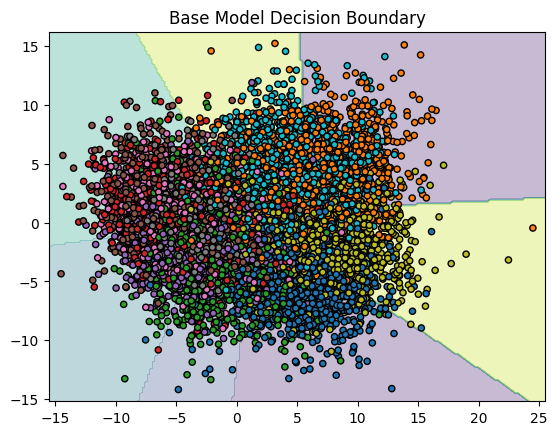

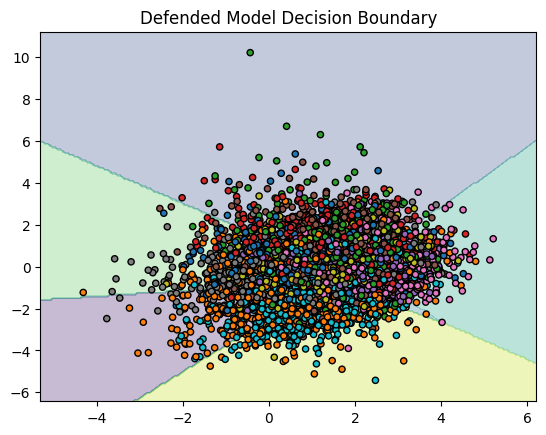

In [63]:
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

def get_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            # Extract penultimate layer output
            # Assuming your model has attribute `fc1` before final layer
            x = model.pool(F.relu(model.conv1(inputs)))
            x = model.pool(F.relu(model.conv2(x)))
            x = x.view(x.size(0), -1)
            x = F.relu(model.fc1(x))  # embeddings here
            embeddings.append(x.cpu().numpy())
            labels.append(targets.numpy())
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

def plot_decision_boundary_2d(X, y, title="Decision Boundary"):
    # Train simple classifier on 2D data
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = clf.predict(grid)
    preds = preds.reshape(xx.shape)

    plt.contourf(xx, yy, preds, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20, cmap='tab10')
    plt.title(title)
    plt.show()

emb_base, labels_base = get_embeddings(model_base, test_loader, device)
# Reduce to 2D with PCA
pca = PCA(n_components=2)
emb_base_2d = pca.fit_transform(emb_base)
plot_decision_boundary_2d(emb_base_2d, labels_base, title="Base Model Decision Boundary")

# Similarly for defended model
emb_def, labels_def = get_embeddings(model_dropout, test_loader, device)
emb_def_2d = pca.transform(emb_def)  # Use same PCA transform
plot_decision_boundary_2d(emb_def_2d, labels_def, title="Defended Model Decision Boundary")


### Conducting Gradient Sensitivity Analysis

In [64]:
def gradient_sensitivity(model, dataloader, device):
    model.eval()
    grad_norms = []
    for inputs, labels in dataloader:
        inputs = inputs.to(device).requires_grad_(True)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grads = inputs.grad.detach()
        norms = grads.view(grads.size(0), -1).norm(p=2, dim=1).cpu().numpy()
        grad_norms.extend(norms)
    return np.array(grad_norms)

# Compute gradient norms for both models
grad_norms_base = gradient_sensitivity(model_base, test_loader, device)
grad_norms_def = gradient_sensitivity(model_dropout, test_loader, device)


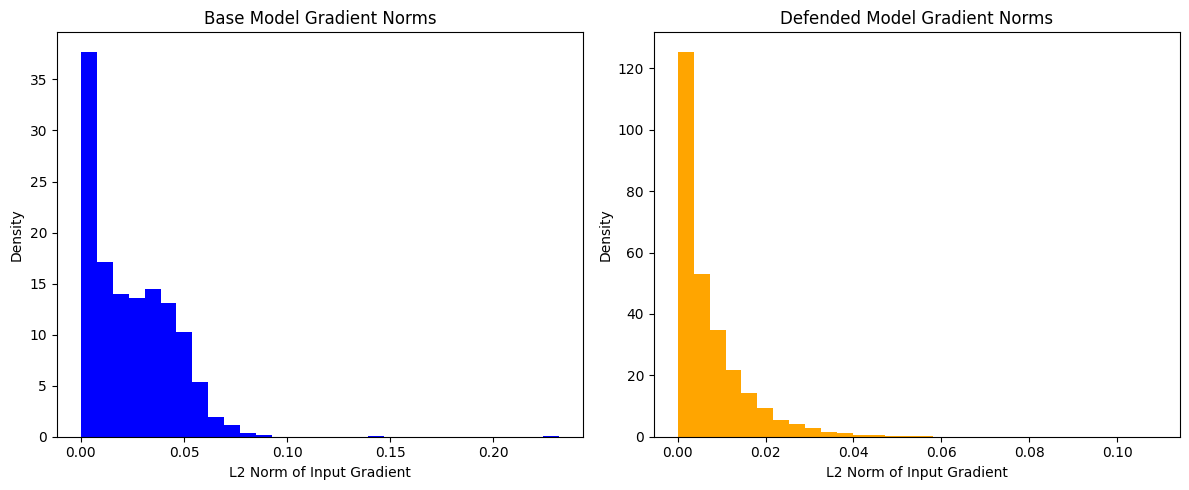

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].hist(grad_norms_base, bins=30, color='blue', density=True)
axs[0].set_title("Base Model Gradient Norms")
axs[0].set_xlabel("L2 Norm of Input Gradient")
axs[0].set_ylabel("Density")

axs[1].hist(grad_norms_def, bins=30, color='orange', density=True)
axs[1].set_title("Defended Model Gradient Norms")
axs[1].set_xlabel("L2 Norm of Input Gradient")
axs[1].set_ylabel("Density")

plt.tight_layout()
plt.show()